In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
weather = pd.read_csv('donetsk_17_21_with_storms.csv', sep=';', header=0, parse_dates=True, squeeze=True)
code = weather.pop('code')

In [11]:
weather['wind_direction'] = weather['wind_direction']*10
wv = weather.pop('wind_speed')

# Convert to radians.
wd_rad = weather.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
weather['w_x'] = wv*np.cos(wd_rad)
weather['w_y'] = wv*np.sin(wd_rad)
# weather.head()

,started_at,cloud_height,cloud_amount,temperature,temperature_dew,pressure,pressure_tendency,pressure_tendency_value,w_x,w_y
0,2017-09-01 00:00:00,5,8,14.4,13.5,989.4,7,1.3,0.000000,0.000000
1,2017-09-01 03:00:00,5,8,14.2,13.4,989.3,7,0.1,0.000000,0.000000
2,2017-09-01 06:00:00,5,8,15.2,13.2,989.7,3,0.4,0.000000,0.000000
3,2017-09-01 09:00:00,5,6,17.7,13.2,988.9,8,0.8,-0.684040,-1.879385
4,2017-09-01 12:00:00,5,7,16.5,13.4,989.1,3,0.2,-1.368081,-3.758770


In [12]:
date_time = pd.to_datetime(weather.pop('started_at'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

weather['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
weather['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
weather['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
weather['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
weather['code'] = code
weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cloud_height,11360.0,6.929049e+00,2.159598,2.0,5.000000,6.000000e+00,9.000000,10.0
cloud_amount,11360.0,4.674912e+00,3.246734,0.0,0.000000,6.000000e+00,8.000000,9.0
temperature,11360.0,1.070515e+01,10.880943,-20.8,1.200000,1.030000e+01,19.700000,37.8
temperature_dew,11360.0,4.112782e+00,7.817085,-22.0,-1.500000,4.200000e+00,10.400000,21.5
pressure,11360.0,9.926527e+02,7.295076,964.2,987.900000,9.920000e+02,997.500000,1015.3
pressure_tendency,11360.0,4.805722e+00,2.476551,1.0,2.000000,4.000000e+00,7.000000,8.0
pressure_tendency_value,11360.0,7.352113e-01,0.648641,0.0,0.300000,6.000000e-01,1.000000,7.1
w_x,11360.0,-1.415475e-02,2.134740,-10.0,-1.285575,0.000000e+00,1.285575,10.0
w_y,11360.0,4.804220e-01,2.820315,-10.0,-0.684040,0.000000e+00,1.879385,16.0
day_sin,11360.0,6.531552e-15,0.707138,-1.0,-0.707107,1.611396e-14,0.707107,1.0


In [15]:
# Split the dataframe into train, validation, and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(weather, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7270 train examples
1818 validation examples
2272 test examples


In [17]:
train_data_file = "train_data.csv"
valid_data_file = "valid_data.csv"
test_data_file = "test_data.csv"

train.to_csv(train_data_file, index=False, header=False)
val.to_csv(valid_data_file, index=False, header=False)
test.to_csv(test_data_file, index=False, header=False)

In [18]:
CSV_HEADER = [
    "cloud_height",
    "cloud_amount",
    "temperature",
    "temperature_dew",
    "pressure",
    "pressure_tendency",
    "pressure_tendency_value",
    "w_x",
    "w_y",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
    "code",
]
TARGET_FEATURE_NAME = "code"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]

FLOAT_FEATURE_NAMES = [
    "cloud_height",
    "cloud_amount",
    "temperature",
    "temperature_dew",
    "pressure",
    "pressure_tendency",
    "pressure_tendency_value",
    "w_x",
    "w_y",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]

# NUMERIC_FEATURE_NAMES = [
#     "cloud_height",
#     "cloud_amount",
#     "pressure_tendency",
# ]

# CATEGORICAL_FEATURES_WITH_VOCABULARY = {
#     "cloud_height": list(weather["cloud_height"].unique()),
#     "cloud_amount": list(weather["cloud_amount"].unique()),
#     "pressure_tendency": list(weather["pressure_tendency"].unique())
# }

# CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# FEATURE_NAMES = NUMERIC_FEATURE_NAMES + FLOAT_FEATURE_NAMES #CATEGORICAL_FEATURE_NAMES
FEATURE_NAMES = FLOAT_FEATURE_NAMES

# COLUMN_DEFAULTS = [
#     [0.0] if feature_name in NUMERIC_FEATURE_NAMES + FLOAT_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
#     for feature_name in CSV_HEADER
# ]
COLUMN_DEFAULTS = [[0], [0], [0.0], [0.0], [0.0], [0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [19]:
def process(features, target):
    for feature_name in features:
        if feature_name in FLOAT_FEATURE_NAMES: #CATEGORICAL_FEATURES_WITH_VOCABULARY:
            # Cast categorical feature values to string.
            features[feature_name] = tf.cast(features[feature_name], tf.dtypes.float32)
    # Get the instance weight.
#     weight = features.pop(WEIGHT_COLUMN_NAME)
    return features, target
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        shuffle=shuffle,
    ).map(process)

    return dataset

In [20]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(), dtype=tf.float32
        )
    return inputs

In [48]:
def encode_inputs(inputs, encoding_size):
    encoded_features = []
    for feature_name in inputs:
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
#         encoded_feature = layers.Dropout(0.2)(encoded_feature) # mwm
#         encoded_feature = layers.Dense(units=encoding_size, activation='relu')(encoded_feature) # mwm
        encoded_features.append(encoded_feature)
    return encoded_features

In [49]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super(GatedLinearUnit, self).__init__()
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

In [50]:
class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate):
        super(GatedResidualNetwork, self).__init__()
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

In [51]:
class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate):
        super(VariableSelection, self).__init__()
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs

In [71]:
def create_model(encoding_size):
    inputs = create_model_inputs()
    feature_list = encode_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )
    features = layers.Dropout(0.3)(features) # mwm
#     outputs = layers.Dense(units=1, activation="sigmoid")(features)
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [72]:
learning_rate = 0.001
dropout_rate = 0.15
batch_size = 265
num_epochs = 20
encoding_size = 16

model = create_model(encoding_size)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)


# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

print("Start training the model...")
train_dataset = get_dataset_from_csv(
    train_data_file, shuffle=True, batch_size=batch_size
)
valid_dataset = get_dataset_from_csv(valid_data_file, batch_size=batch_size)
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)
print("Model training finished.")

print("Evaluating model performance...")
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
_, accuracy = model.evaluate(test_dataset)
print("Test accuracy: ", round(accuracy * 100, 2))

Start training the model...
Epoch 1/20
28/28 [==============================] - 2s 85ms/step - accuracy: 0.9018 - loss: 0.6925 - val_loss: 0.6995 - val_accuracy: 0.9032
Epoch 2/20
28/28 [==============================] - 1s 32ms/step - accuracy: 0.9018 - loss: 0.6870 - val_loss: 0.6983 - val_accuracy: 0.9032
Epoch 3/20
28/28 [==============================] - 1s 34ms/step - accuracy: 0.9018 - loss: 0.6857 - val_loss: 0.6981 - val_accuracy: 0.9032
Epoch 4/20
28/28 [==============================] - 1s 34ms/step - accuracy: 0.9018 - loss: 0.6851 - val_loss: 0.6979 - val_accuracy: 0.9032
Epoch 5/20
28/28 [==============================] - 1s 34ms/step - accuracy: 0.9018 - loss: 0.6848 - val_loss: 0.6978 - val_accuracy: 0.9032
Epoch 6/20
28/28 [==============================] - 1s 35ms/step - accuracy: 0.9018 - loss: 0.6845 - val_loss: 0.6978 - val_accuracy: 0.9032
Epoch 7/20
28/28 [==============================] - 1s 35ms/step - accuracy: 0.9018 - loss: 0.6844 - val_loss: 0.6978 - val_ac

In [73]:
model.save('storm_donetsk_multiclass_grn_vsn_model')

INFO:tensorflow:Assets written to: storm_donetsk_multiclass_grn_vsn_model/assets


In [74]:
from datetime import datetime
import time
def prepare_data(date_term, telegram, model_name):
    ret = {}
    ret['cloud_height'] = int(telegram[14:15])
    ret['cloud_amount'] = int(telegram[18:19])
    ret['pressure_tendency'] = int(telegram[49:50])
    sign = ''
    if telegram[25:26] == '1':
        sign = '-'
    ret['temperature'] = float(sign+telegram[26:28]+'.'+telegram[28:29])
    sign = ''
    if telegram[31:32] == '1':
        sign = '-'
    ret['temperature_dew'] = float(sign+telegram[32:34]+'.'+telegram[34:35])
    p1 = '1'
    if telegram[37:38] != '0':
        p1 = ''
    ret['pressure'] = float(p1+telegram[37:40]+'.'+telegram[40:41])
    ret['pressure_tendency_value'] = float(telegram[50:52]+'.'+telegram[52:53])
    wv = float(telegram[21:23]+'.')
    wd_rad = int(telegram[19:21])*10*np.pi/180
    ret['w_x'] = wv*np.cos(wd_rad)
    ret['w_y'] = wv*np.sin(wd_rad)
    d = datetime.strptime(date_term, "%Y-%m-%d %H:%M:%S")
    s = time.mktime(d.timetuple())
    day = 24*60*60
    year = (365.2425)*day
    ret['day_sin'] = np.sin(s * (2 * np.pi / day))
    ret['day_cos'] = np.cos(s * (2 * np.pi / day))
    ret['year_sin'] = np.sin(s * (2 * np.pi / year))
    ret['year_cos'] = np.cos(s * (2 * np.pi / year))
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in ret.items()}
    model = tf.keras.models.load_model(model_name)
    predictions = model.predict(input_dict)
    
    return predictions

d_t = '2021-08-25 06:00:00'
telegram = 'ЩЭСМЮ 34519 32997 01602 10216 20136 39929 40164 54000 333 20160 555 10029='
predictions = prepare_data(d_t, telegram, 'storm_donetsk_multiclass_grn_vsn_model')
# prob = tf.nn.sigmoid(predictions[0])
# print(
#     "Вероятность ухудшения видимости в оставшееся до срока время %.1f проц. "
#     % (100 * predictions[0][0])
# )

<BarContainer object of 9 artists>

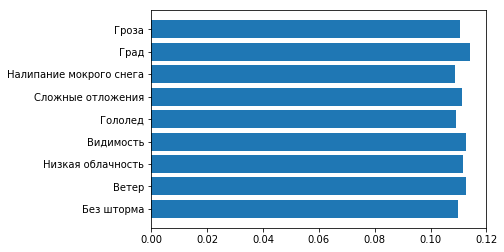

In [75]:
import matplotlib.pyplot as plt
storm = ('Без шторма', 'Ветер', 'Низкая облачность', 'Видимость', 'Гололед', 'Сложные отложения', 'Налипание мокрого снега', 'Град', 'Гроза')
fig, ax = plt.subplots()
ax.barh(storm, np.squeeze(predictions))

In [70]:
predictions

array([[0.109662  , 0.11439317, 0.11177427, 0.11011418, 0.1105405 ,
        0.11098607, 0.1082915 , 0.11222147, 0.11201683]], dtype=float32)